<a href="https://colab.research.google.com/github/thravt/AIProjectsHomework/blob/main/HW4_Tyler_Thraves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 (50 points): In this task, you will pick a dataset (time-series or any other form of sequential data) and an associated problem that can be solved via sequence models. You must describe why you need sequence models to solve this problem. Include a link to the dataset source. Next, you should pick an RNN framework that you would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other Python Package).

When searching for a good dataset to work with, I decided on a next word predictor for THE SIGN OF THE FOUR. I was originally going to use the entirety of the Adventures of Sherlock Holmes, but I ran into ram issues. I then tried just the first story, but that ran into issues with overfitting, so I figured the increased data should help. This is just small enough to not have ram issues, so hopefully there's no issue with overfitting. The link to the text can be found here: https://sherlock-holm.es/stories/plain-text/sign.txt. I need sequence models for this problem, as there are time dependencies in these predictions, as the closer words have more immediate value.

**Part 1 (10 points): Implement your RNN either using an existing framework OR you can
implement your own RNN cell structure. In either case, describe the structure of your
RNN and the activation functions you are using for each time step and in the output
layer. Define a metric you will use to measure the performance of your model (NOTE:
Performance should be measured both for the validation set and the test set).**

For the RNN framework, I will be using Tensorflow's built in layers.SimpleRNN as described here https://www.tensorflow.org/guide/keras/working_with_rnns. I will need to start by tokenizing the data, to get it into more usable chunks. Then I will create n grams from those tokenized sentences and pad those sentences to even lengths. Finally, I will convert the y values to one-hot, run the data through embedding, and through the model.

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files

files.upload()

Saving sherlock.txt to sherlock.txt


{'sherlock.txt': b'\n\n\n\n                              THE SIGN OF THE FOUR\n\n                               Arthur Conan Doyle\n\n\n\n\n\n\n\n                                Table of contents\n        The Science of Deduction\n        The Statement of the Case\n        In Quest of a Solution\n        The Story of the Bald-Headed Man\n        The Tragedy of Pondicherry Lodge\n        Sherlock Holmes Gives a Demonstration\n        The Episode of the Barrel\n        The Baker Street Irregulars\n        A Break in the Chain\n        The End of the Islander\n        The Great Agra Treasure\n        The Strange Story of Jonathan Small\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          CHAPTER I\n          The Science of Deduction\n\n\n     Sherlock Holmes took his bottle from the corner of the mantelpiece\n     and his hypodermic syringe from its neat morocco case. With his long,\n     white, nervous fingers he adjusted the delicate needle, and rolled\n     back his left shirt-cuff. For some littl

Downloaded data, time to open

In [ ]:
with open('sherlock.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [ ]:
#Tokenize the text file
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1

In [ ]:
print(total_words)
print(tokenizer.word_index)

5523
{'the': 1, 'i': 2, 'and': 3, 'of': 4, 'a': 5, 'to': 6, 'in': 7, 'it': 8, 'he': 9, 'that': 10, 'was': 11, 'you': 12, 'his': 13, 'is': 14, 'with': 15, 'had': 16, 'my': 17, 'at': 18, 'have': 19, 'we': 20, 'as': 21, 'for': 22, 'but': 23, 'be': 24, 'which': 25, 'me': 26, 'this': 27, 'said': 28, 'there': 29, 'him': 30, 'no': 31, 'upon': 32, 'not': 33, 'all': 34, 'on': 35, 'one': 36, 'from': 37, 'our': 38, 'so': 39, 'were': 40, 'out': 41, 'an': 42, 'if': 43, 'could': 44, 'man': 45, 'up': 46, 'us': 47, 'would': 48, 'by': 49, 'are': 50, 'holmes': 51, 'been': 52, 'they': 53, 'her': 54, 'what': 55, 'some': 56, 'very': 57, 'she': 58, 'or': 59, 'your': 60, 'see': 61, "'": 62, 'down': 63, 'has': 64, 'now': 65, 'then': 66, 'will': 67, 'when': 68, 'into': 69, 'can': 70, 'well': 71, 'little': 72, 'here': 73, 'small': 74, 'over': 75, 'them': 76, 'about': 77, 'do': 78, 'however': 79, 'who': 80, 'treasure': 81, 'more': 82, 'should': 83, 'way': 84, 'night': 85, 'shall': 86, 'time': 87, 'may': 88, 'oth

In [ ]:
#get n grams for data
Dataset = []
#split up the lines by the \n delimiter
for sentence in text.split('\n'):
  token_list = tokenizer.texts_to_sequences([sentence])[0]
  #add the token for each word and the stuff before it in the token
  for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        Dataset.append(n_gram_sequence)


We could use the tokenizer to turn the n-grams back into sentences/partial sentences, but that won't be useful until the decoder. But for now we have to pad these until they are all the same length for the model.

In [ ]:
max_len = max([len(i) for i in Dataset])
Dataset = np.array(tf.keras.preprocessing.sequence.pad_sequences(Dataset, maxlen=max_len, padding='pre'))

In [ ]:
print(Dataset)
print(len(Dataset))

[[   0    0    0 ...    0    1  266]
 [   0    0    0 ...    1  266    4]
 [   0    0    0 ...  266    4    1]
 ...
 [   0    0    0 ...    1 5520 5521]
 [   0    0    0 ... 5520 5521 1553]
 [   0    0    0 ... 5521 1553 5522]]
39952


The dataset now contains sentences of the proper length padded with 0s. By taking off the last encoded word, I can now easily split the data into inputs and output. I then need to convert y into one-hot encodings. After that, I need to split into training/validation/test sets. I can simply split with the existing time frame, as I've heard a temporal split will work best.

In [ ]:
X = Dataset[:, :-1]
y = Dataset[:, -1]

In [ ]:
print(len(X))

39952


In [ ]:
y = np.array(tf.keras.utils.to_categorical(y, num_classes=total_words))

In [ ]:
#import the needed library
from sklearn.model_selection import train_test_split

In [ ]:
X_train = X[:-1000]
X_val = X[-1000:-500]
X_test = X[-500:]

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

38952
500
500


In [ ]:
y_train = y[:-1000]
y_val = y[-1000:-500]
y_test = y[-500:]

Now it's time to make the model. I'll need an embedder, a SimpleRNN layer, and finally a Dense layer to get the final output.

In [ ]:
#making the model
model = keras.Sequential()
model.add(layers.Embedding(total_words, 100, input_length=max_len-1))
model.add(layers.SimpleRNN(150))
model.add(layers.Dense(total_words, activation = 'softmax'))
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


For this model, I will be using categorical cross-entropy due to the non-binary nature of the data. I will also use adam for the optimizer due to the higher degree of accuracy it tends to have, and it worked well in previous homeworks.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


I'll be checking the validation every 20 or so epochs to make sure there's no overfitting.

In [ ]:
history = model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 47s 36ms/step - accuracy: 0.0600 - loss: 6.6954
Epoch 2/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.0957 - loss: 5.7481
Epoch 3/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 0.1268 - loss: 5.2216
Epoch 4/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - accuracy: 0.1533 - loss: 4.7153
Epoch 5/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.1836 - loss: 4.2739
Epoch 6/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.2336 - loss: 3.8434
Epoch 7/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.2890 - loss: 3.4762
Epoch 8/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.3521 - loss: 3.1083
Epoch 9/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.4161 - loss: 2.7652
Epoch 10/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.4721 - loss: 2.5003
Epoch 11/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5216 - loss: 2.2402
Epoch 12

First thing is that this definetly takes longer than the other models I've done, probably due to the time element and increased categorical answers. I know I said that I'd check validation at every 20 epochs, but it'd take like half an hour to run again, so I'm not sure I will keep it going, especially since the accuracy already isn't bad at 77.5%.

In [ ]:
loss_values = history.history['loss']

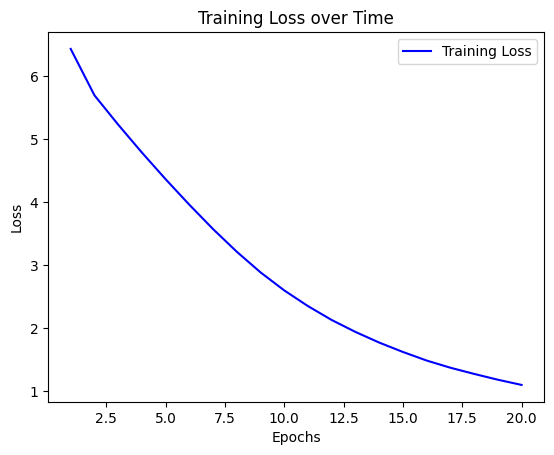

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
accuracy_values = history.history['accuracy']

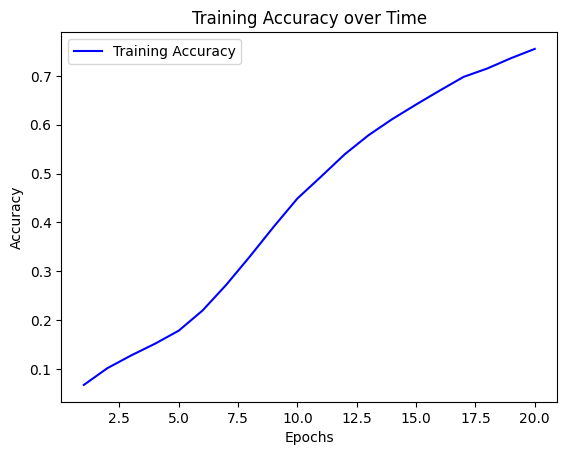

In [ ]:
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.title('Training Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Train set seems good so far, time for validation and test

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0662 - loss: 7.1570


In [ ]:
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Loss: 7.3713
Validation Accuracy: 0.0780


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0847 - loss: 8.6264


In [ ]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 9.5793
Test Accuracy: 0.0740


That's pretty bad, I'll try reducing the model complexity.

In [ ]:
#making the model
model = keras.Sequential()
model.add(layers.Embedding(total_words, 50, input_length=max_len-1))
model.add(layers.SimpleRNN(75))
model.add(layers.Dense(total_words, activation = 'softmax'))
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.0555 - loss: 6.7566
Epoch 2/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.0790 - loss: 5.9056
Epoch 3/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.1082 - loss: 5.4735
Epoch 4/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.1253 - loss: 5.1553
Epoch 5/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.1442 - loss: 4.8740
Epoch 6/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.1651 - loss: 4.6178
Epoch 7/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.1879 - loss: 4.3706
Epoch 8/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.2068 - loss: 4.1531
Epoch 9/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.2349 - loss: 3.9451
Epoch 10/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.2554 - loss: 3.7788
Epoch 11/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.2878 - loss: 3.5706
Epoch 12

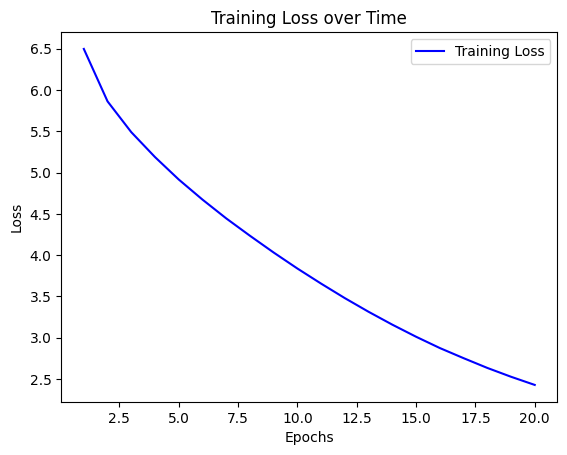

In [ ]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

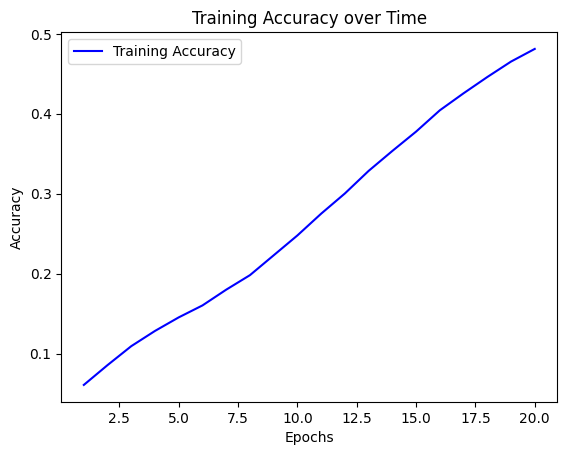

In [ ]:
accuracy_values = history.history['accuracy']
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.title('Training Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1203 - loss: 6.2187


In [ ]:
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Loss: 6.3805
Validation Accuracy: 0.1000


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1043 - loss: 7.4759


In [ ]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 8.5088
Test Accuracy: 0.0880


Ok, relative to the train accuracy, it's not as bad, but it's still pretty bad. Clearly I'm doing something wrong. I'll try adding a regularization effect with kernel_regularizer.

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
#making the model
model = keras.Sequential()
model.add(layers.Embedding(total_words, 100, input_length=max_len-1))
model.add(layers.SimpleRNN(150, kernel_regularizer=l2(0.01)))
model.add(layers.Dense(total_words, activation = 'softmax'))
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.0566 - loss: 6.9426
Epoch 2/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.0671 - loss: 6.1449
Epoch 3/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.0696 - loss: 5.9735
Epoch 4/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.0812 - loss: 5.7774
Epoch 5/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.0963 - loss: 5.4645
Epoch 6/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.1041 - loss: 5.2101
Epoch 7/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.1124 - loss: 4.9857
Epoch 8/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.1317 - loss: 4.7765
Epoch 9/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.1517 - loss: 4.5745
Epoch 10/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.1745 - loss: 4.3912
Epoch 11/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.1946 - loss: 4.2314
Epoch 12

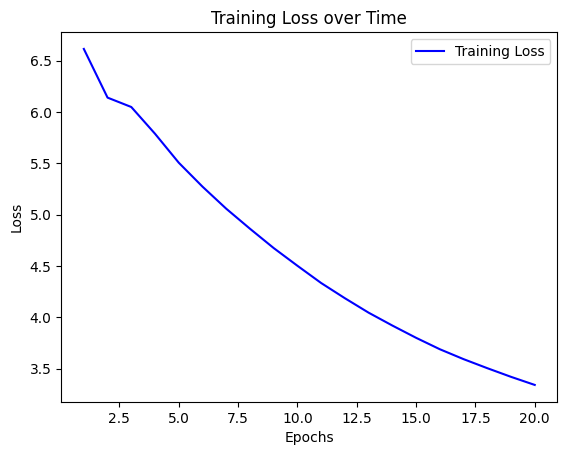

In [ ]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

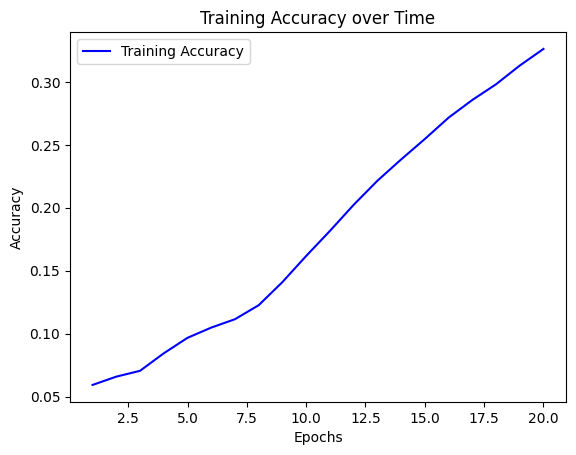

In [ ]:
accuracy_values = history.history['accuracy']
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.title('Training Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0831 - loss: 6.2359


In [ ]:
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Loss: 6.4340
Validation Accuracy: 0.0940


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0911 - loss: 7.4170


In [ ]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 8.2875
Test Accuracy: 0.0740


Ok yeah that didn't work either. After searching online and getting advice in office hours I came across this https://www.kaggle.com/code/prashantsparhad/bidirectional-rnn which seems to indicate that a bidirectional RNN would be less prone to overfitting, which seems to be a big issue at the amount of data I have and current model features. Such a model is outside the scope of the current homework, but I'll remember it for future projects.

**Part 2 (30 points): Update your network from part 1 with first an LSTM and then a GRU
based cell structure (You can treat both as 2 separate implementations). Re-do the
training and performance evaluation. What are the major differences you notice? Why
do you think those differences exist between the 3 implementations (basic RNN, LSTM
and GRU)?**

In order to have a fair comparison, I will use the first model, but replacing the SimpleRNN with the given layer, starting with LSTM.

In [ ]:
#making the model
model = keras.Sequential()
model.add(layers.Embedding(total_words, 100, input_length=max_len-1))
model.add(layers.LSTM(150))
model.add(layers.Dense(total_words, activation = 'softmax'))
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.0544 - loss: 6.7329
Epoch 2/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 79s 53ms/step - accuracy: 0.0743 - loss: 6.0029
Epoch 3/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 84s 55ms/step - accuracy: 0.1065 - loss: 5.5697
Epoch 4/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 81s 55ms/step - accuracy: 0.1240 - loss: 5.2434
Epoch 5/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 80s 53ms/step - accuracy: 0.1442 - loss: 4.8984
Epoch 6/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.1678 - loss: 4.5572
Epoch 7/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 66s 54ms/step - accuracy: 0.1887 - loss: 4.2526
Epoch 8/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.2139 - loss: 3.9818
Epoch 9/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 83s 55ms/step - accuracy: 0.2525 - loss: 3.6974
Epoch 10/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - accuracy: 0.2891 - loss: 3.4343
Epoch 11/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.3344 - loss: 3.1756
Epoch 12

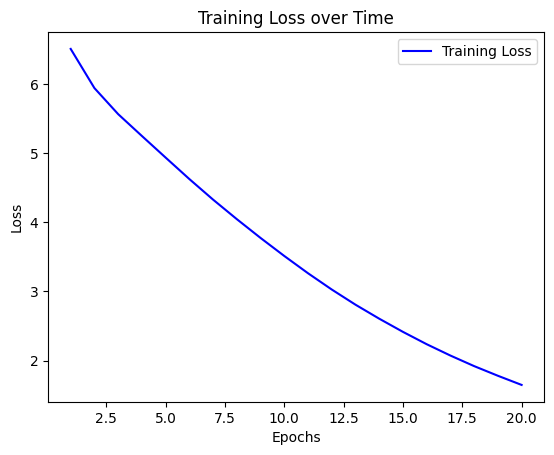

In [ ]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

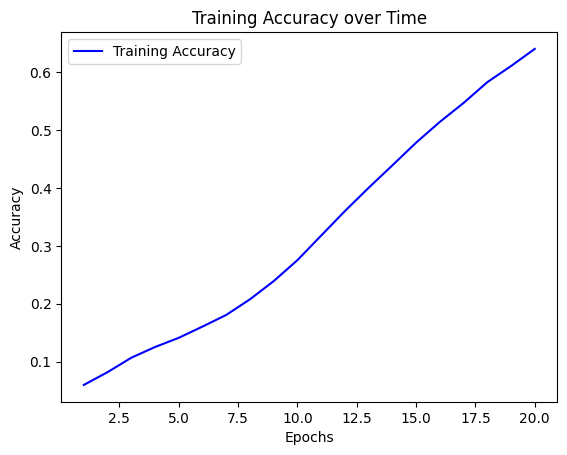

In [ ]:
accuracy_values = history.history['accuracy']
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.title('Training Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Accuracy is better than trying to reduce complexity, but not as good as the simpleRNN. More epochs might fix that, but for now it's time to see how the validation and test set did.

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1085 - loss: 6.6751


In [ ]:
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Loss: 6.9089
Validation Accuracy: 0.0900


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0877 - loss: 8.1022
Test Loss: 9.1053
Test Accuracy: 0.0720


The model is definitely still overfitting, but as opposed to the simple model, the validation accuracy is higher than the test accuracy. With how close the accuracy was to the original, with a lower training accuracy, it seems that given more training time the LSTM would be a better model.

Time for the GRU.

In [ ]:
#making the model
model = keras.Sequential()
model.add(layers.Embedding(total_words, 100, input_length=max_len-1))
model.add(layers.GRU(150))
model.add(layers.Dense(total_words, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history = model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 77s 59ms/step - accuracy: 0.0577 - loss: 6.7778
Epoch 2/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.0996 - loss: 5.6805
Epoch 3/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 81s 56ms/step - accuracy: 0.1287 - loss: 5.2109
Epoch 4/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.1503 - loss: 4.7856
Epoch 5/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 67s 55ms/step - accuracy: 0.1765 - loss: 4.3888
Epoch 6/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.2161 - loss: 3.9533
Epoch 7/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.2644 - loss: 3.5797
Epoch 8/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 67s 55ms/step - accuracy: 0.3210 - loss: 3.2320
Epoch 9/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.3779 - loss: 2.9140
Epoch 10/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 67s 55ms/step - accuracy: 0.4314 - loss: 2.6249
Epoch 11/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 68s 55ms/step - accuracy: 0.4804 - loss: 2.3682
Epoch 12

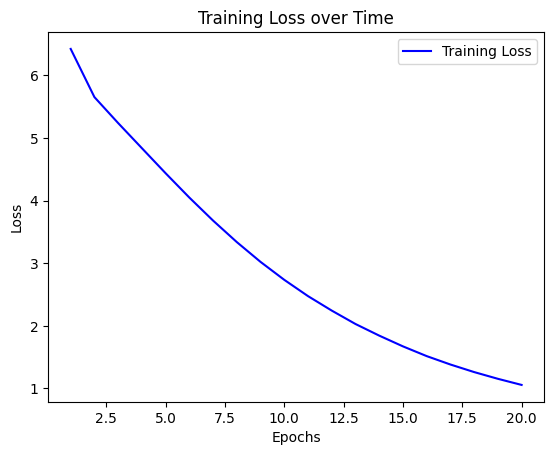

In [ ]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

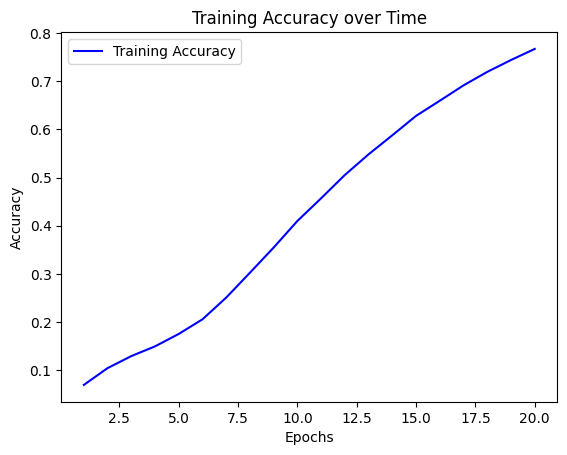

In [ ]:
accuracy_values = history.history['accuracy']
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.title('Training Accuracy over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Ok, that's a slight improvement over the base RNN, time to see if the validation and test sets have better accuracy.

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0816 - loss: 7.2598
Validation Loss: 7.4301
Validation Accuracy: 0.0860


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0841 - loss: 8.4146
Test Loss: 9.4874
Test Accuracy: 0.0700


The answer seems to be no, the validation and test sets are still just as bad.

The SimpleRNN had the best real time accuracy improvement, whereas LSTM and GRU took around twice as long, where LSTM also didn't have as good of an accuracy. The sentences may not have been long enough for LSTM to make enough of an improvement, so the additional complexity was more of a hinderance. The GRU did not outperform the SimpleRNN, which leads me to believe that the overfitting was not a result of a vanishing gradient, as GRU tends to be much better than SimpleRNN at dealing with that. Combining GRU and LSTM in a bidirectional model would likely be best, as well as implementing dropout to deal with the overfitting. This seems like it would do best to me, but I don't have confidence in my computer being able to run such a model, and it goes a bit beyond the scope of this homework.

**Part 3 (10 points): Can you use the traditional feed-forward network to solve the same
problem. Why or why not? (Hint: Can time series data be converted to usual features
that can be used as input to a feed-forward network?)**

I would not be able to use a traditional network to solve the same problem. A traditional network treats each element as unrelated, so extra features would have to be implemented in order to try and hardcode these relations. It would technically be possible to code something similar, but it would take a lot of preprocessing and important information may be lost in the conversion from time series data. I'd imagine you would be able to code features of previous values, but that may rapidly increase the complexity for more variables, and they would all have to have the same amount of features,

# Task 3 (50 points):

**Part 1: Implementing Word Embeddings (10 points)**

**Use a pre-trained word embedding model (Word2Vec, GloVe, FastText, or BERT
embeddings).
Provide a comparative discussion on why you chose this embedding over others.**

For this task I will be using word2vec-google-news-300, being implemented in Gensim. I chose that model as it being from news data should give it a good variety of words to be used, with large vectors to work with. I figure a more complicated model wouldn't be needed, as parts 2 and 3 only deal with similarity, and not some more complicated use.

**Load embeddings efficiently (either from pre-trained vectors or using an NLP library like
Gensim, SpaCy, or Hugging Face).**

I will be using Gensim to load the embeddings.

In [2]:
!pip install gensim

In [3]:
#imports for gensim
import gensim.downloader
import gensim


In [4]:
Word2Vec_vectors = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Well, it took a while to load, but it didn't really use up any ram, so that shouldn't be a problem, just that I might want something better than a laptop when I get a job.

**Allow dynamic user input of two words and output their respective embeddings.**

This should be simple. Gensim already easily returns the vectors of a single word, I just need a function to do that twice.

In [5]:
def DoubleVector(model, word1, word2):
  return model[word1], model[word2]

In [ ]:
#testing
print(DoubleVector(Word2Vec_vectors, 'help', 'time'))

(array([ 0.04980469,  0.06640625,  0.03833008,  0.02355957, -0.02148438,
        0.20898438,  0.06396484, -0.02282715, -0.04101562, -0.26757812,
        0.1015625 ,  0.10693359, -0.06591797,  0.16992188, -0.0078125 ,
       -0.07861328, -0.06591797,  0.12060547, -0.00390625, -0.02770996,
        0.19238281,  0.13183594,  0.16113281, -0.07324219, -0.22167969,
       -0.05102539, -0.12255859,  0.06298828,  0.01080322, -0.12695312,
        0.04614258, -0.01794434, -0.03222656, -0.21484375, -0.01696777,
        0.0098877 , -0.00976562, -0.05175781,  0.12011719,  0.04980469,
        0.01867676,  0.05712891, -0.04492188, -0.16113281, -0.08105469,
       -0.09960938, -0.19824219, -0.00109863,  0.01239014,  0.23144531,
       -0.06738281,  0.08105469, -0.0177002 , -0.12402344, -0.14746094,
       -0.10253906, -0.23046875, -0.03149414,  0.03125   , -0.09033203,
        0.08251953, -0.09326172, -0.21679688,  0.06103516,  0.046875  ,
       -0.03466797, -0.05908203,  0.12695312, -0.0025177 ,  0.0

**Handle cases where a word is out of vocabulary (OOV) and suggest ways to approximate
its embedding.**

A very easy way to handle this is to simply return the zero vector, which I will do right now.

In [6]:
def WordInVec(model, word):
  if word in model:
    return model[word]
  return np.zeros(len(model[0]))

In [ ]:
#Testing:
print(WordInVec(Word2Vec_vectors, 'time'))
print(WordInVec(Word2Vec_vectors, 'asdfuwqejflwqelkhf'))

[-4.73632812e-02  1.87500000e-01  2.25830078e-03  1.73828125e-01
 -1.59912109e-02 -1.50390625e-01  1.13769531e-01 -1.55029297e-02
  2.19726562e-01 -1.01318359e-02  1.50146484e-02 -1.03515625e-01
  5.34057617e-03 -6.59179688e-02 -1.92382812e-01  3.89099121e-03
  1.42211914e-02  8.30078125e-02  1.30859375e-01 -1.95312500e-01
 -1.19628906e-01 -9.57031250e-02 -4.90722656e-02  6.10351562e-03
 -1.31225586e-02  1.25976562e-01  5.37109375e-02  4.56542969e-02
  3.32031250e-02  1.56250000e-01  1.33666992e-02  4.39453125e-02
 -4.68750000e-02  1.39648438e-01  1.58203125e-01 -4.88281250e-02
  1.11694336e-02 -1.96289062e-01 -7.17773438e-02  1.82617188e-01
  1.36718750e-01 -7.37304688e-02  1.73828125e-01 -8.69140625e-02
 -1.83105469e-02  5.61523438e-02 -1.62353516e-02  1.57226562e-01
 -4.76074219e-02  8.25195312e-02  4.58984375e-02 -1.33789062e-01
 -3.32031250e-02 -2.62451172e-02 -9.32617188e-02  5.54199219e-02
  1.57226562e-01  6.93359375e-02  3.01513672e-02 -9.22851562e-02
 -1.03027344e-01 -1.01470

Word2Vec doesn't really have a way to handle OOV words, so often simply using the zero vector like I did is how they're handled. Models like FastText or BERT can break the words into smaller subwords and learn embeddings for those, but this model can't do that. Another thing I could do would be simply take the average of all of the existing vectors, but that isn't ideal either. There's not really a good answer for this model.

**Part 2: Cosine Similarity Computation (20 points)**

**Implement a function that computes the cosine similarity between two-word
embeddings.**

Cosine similarity is found by taking the dot product of the vectors, and dividing it by the product of the vector norms, which in this case is the euclidian norm.

In [7]:
def CosSimilar(vector1, vector2):
  numerator = np.dot(vector1,vector2)
  norm1 = np.sqrt(np.dot(vector1, vector1))
  norm2 = np.sqrt(np.dot(vector2, vector2))
  denominator = norm1 * norm2
  return numerator / denominator

In [ ]:
#Testing
print(CosSimilar(Word2Vec_vectors['time'], Word2Vec_vectors['word']))
print(CosSimilar(Word2Vec_vectors['time'], Word2Vec_vectors['time']))

0.12084979
1.0


**Explain why cosine similarity is useful in word embedding space.**

Cosine similarity is useful in word embedding space as it shows how related 2 words are. It focuses on the meaning of the words, with word with similar meanings having the a similar direction. It also doesn't focus on the magnitude of the vectors, so the strength of the words isn't a factor on their similarity. As a result, the focus of the words is only on their meaning.

**Allow batch processing, where users can input multiple word pairs for simultaneous
similarity computation.**

I'll create a function that takes a list of tuples of words, and run each tuple into the cosine similarity function.

In [8]:
def CosGroup(list, model):
  results = [0] * len(list)
  for i in range(len(list)):
    results[i] = CosSimilar(model[list[i][0]], model[list[i][1]])
  return results

In [ ]:
inputlist = [('I', 'hope'), ('this', 'works'), ('right', 'on'), ('this', 'attempt')]
print(CosGroup(inputlist, Word2Vec_vectors))

[0.15756786, 0.118107796, 0.2935666, 0.09340572]


**Visualization Requirement: Create a 2D or 3D scatter plot (e.g., using PCA or t-SNE) to
visually show how similar and dissimilar words cluster together in the embedding space.**

I will be using PCA to reduce the vectors to 2 dimensions, then use pyplot to plot the points. PCA will be done through sklearn.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
words = Word2Vec_vectors.index_to_key

In [ ]:
vectorlist = Word2Vec_vectors[words]
PcaVecs = pca.fit_transform(vectorlist)

In [9]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(10, 8))
for i, word in enumerate(words):
    x, y = PcaVecs[i]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.title('2D Word2Vec Embeddings with PCA')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f82a78d0cc0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f82a7896660> (for post_execute):


KeyboardInterrupt: 

Well, it's been running for 10 minutes now and it hasn't shown up yet. I don't think it's crashed, as it's still showing that it's executing, and there hasn't been a warning, so I'm going to give it more time.

25 minutes now and still nothing.

45 Minutes.

Ok, the session dropped, but it said it would finish the current execution. If it doesn't work, then I'm just going to pick out some similar and dissimilar words and only plot those.

It's been at least an hour and 45 minutes since I started. I have given up on plotting all of the vectors. Instead I will choose a word, and get some words that are similar, and some that are dissimilar, I'm thinking 10 similar and 5 dissimilar, and only plot those. Fortunately, the most_similar funcition already uses cosine similarity, so I can just use that. I'll have to find dissimilar words manually, but that shouldn't be too hard.

In [ ]:
print(Word2Vec_vectors.most_similar('cat', topn=10))

[('cats', 0.8099379539489746), ('dog', 0.760945737361908), ('kitten', 0.7464985251426697), ('feline', 0.7326234579086304), ('beagle', 0.7150582671165466), ('puppy', 0.7075453400611877), ('pup', 0.6934291124343872), ('pet', 0.6891531348228455), ('felines', 0.6755931973457336), ('chihuahua', 0.6709762215614319)]


The most similar words to cat are: cats, dog, kitten, feline, beagle, puppy, pup, pet, felines, and chihuahua. Now, I'll test some words that shouldn't be similar.

In [ ]:
print(CosGroup([('cat', 'golf'), ('cat', 'teeth'), ('cat', 'disc'), ('cat', 'gas'), ('cat', 'cloud')], Word2Vec_vectors))

[0.15732686, 0.22396284, 0.11265047, 0.08754389, 0.089518026]


Seems all good. Now I'll print the PCA of just these words.

In [ ]:
words = ['cat', 'cats', 'dog', 'kitten', 'feline', 'beagle', 'puppy', 'pup', 'pet', 'felines', 'chihuahua', 'golf', 'teeth', 'disc', 'gas', 'cloud']
vectorlist = Word2Vec_vectors[words]
PcaVecs = pca.fit_transform(vectorlist)

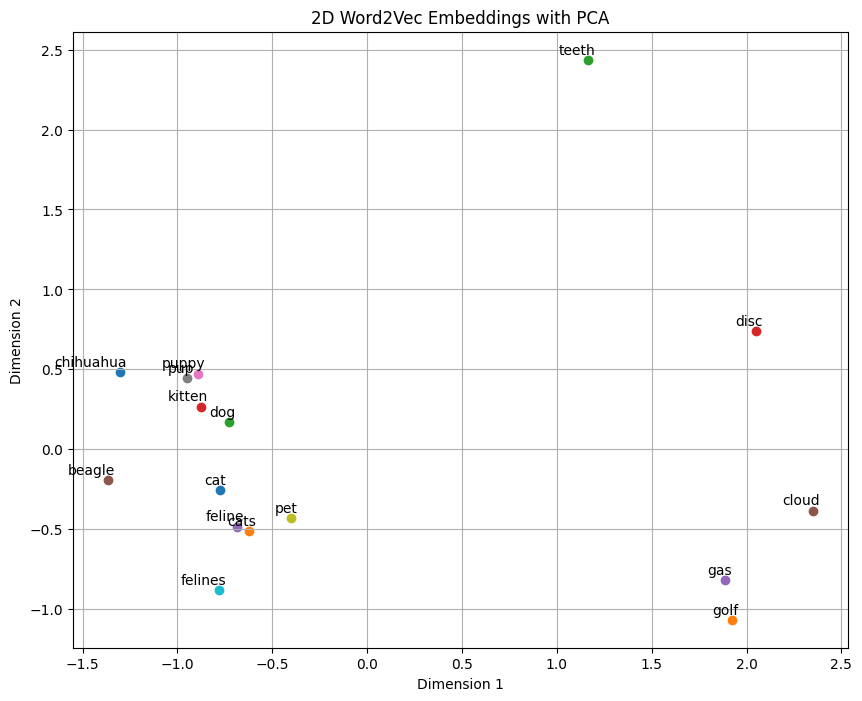

In [ ]:
plt.figure(figsize=(10, 8))
for i, word in enumerate(words):
    x, y = PcaVecs[i]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.title('2D Word2Vec Embeddings with PCA')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

As we can see, the similar words are all clumped together near the left, whereas the dissimilar words are on the right and more spread out. This indicates that similar words will have similar PCA projections, and dissimilar words will have dissimilar PCA projections.

**Part 3: Designing a Novel Dissimilarity Metric (20 points)**

**Define a custom dissimilarity score that goes beyond cosine similarity. Either design your own metric or cite an existing one from literature (provide a proper
reference). Explain why your metric captures novelty/diversity better than cosine
similarity alone.**

For this part I decided to code the euclidean distance. The way it works is that it takes the differences of the vector values, squares them, sums them up, and takes the square root. This way, it's not just the angle between the vectors that's measured, but the magnitude is factored in as well. I believe this will be able to better tell how different the words really are, as I feel that cosine ignoring that aspect could cause valuble data to be lost.

In [10]:
def EuclideanDistance(vec1, vec2):
  vec = vec1 - vec2
  vec = np.square(vec)
  sum = np.sum(vec)
  distance = np.sqrt(sum)
  return distance

In [22]:
print(EuclideanDistance(Word2Vec_vectors['cat'], Word2Vec_vectors['time']))
print(EuclideanDistance(Word2Vec_vectors['cat'], Word2Vec_vectors['cat']))
print(EuclideanDistance(Word2Vec_vectors['cat'], Word2Vec_vectors['kitten']))
print(EuclideanDistance(Word2Vec_vectors['cat'], Word2Vec_vectors['feline']))

3.3446789
0.0
2.3034523
2.2508967


As we can see here, a larger value means the vectors are farther away. It also shows how it differs from cosine, as kitten is shown as farther than feline, when cosine has it the other way around.

**Allow users to toggle between different similarity/dissimilarity measures via function
parameters.**

To do this, I will create a function that takes as an input 2 vectors, and the name of a metric. The function will take the metric name, and put the 2 vectors through the correct metric function.

In [11]:
def Similarity(vector1, vector2, metric='cosine'):
  if (metric == 'cosine'):
    return CosSimilar(vector1, vector2)
  if (metric == 'euclidean'):
    return EuclideanDistance(vector1, vector2)
  print("The given metric does not exist, returning -2")
  return -2

In [12]:
print(Similarity(Word2Vec_vectors['cat'], Word2Vec_vectors['dog'], 'cosine'))
print(Similarity(Word2Vec_vectors['cat'], Word2Vec_vectors['dog'], 'euclidean'))
print(Similarity(Word2Vec_vectors['cat'], Word2Vec_vectors['dog'], 'invalidstring'))

0.76094574
2.0815337
The given metric does not exist, returning -2
-2


**Plot the ranking of words based on their similarity/dissimilarity to a given word
(e.g., how words like "cat" rank against "dog," "lion," and "table" using different
metrics).**

To do this, I'll make a function that will take in a word, a list of words, and a metric, and use that metric to compare the list to the single word. Once I've done that for both metrics, I will plot the loss values, using cosine as the x axis and Euclidean distance as the y axis.

In [19]:
def ListComparison(vector, wlist, metric='cosine'):
  valuelist = np.zeros(len(wlist))
  for i in range(len(wlist)):
    valuelist[i] = Similarity(vector, wlist[i], metric)
  return valuelist

In [20]:
words = ['cat', 'cats', 'dog', 'kitten', 'feline', 'beagle', 'puppy', 'pup', 'pet', 'felines', 'chihuahua', 'golf', 'teeth', 'disc', 'gas', 'cloud']
vectorlist = Word2Vec_vectors[words]
cosinelist = ListComparison(Word2Vec_vectors['cat'], vectorlist, 'cosine')
euclideanlist = ListComparison(Word2Vec_vectors['cat'], vectorlist, 'euclidean')

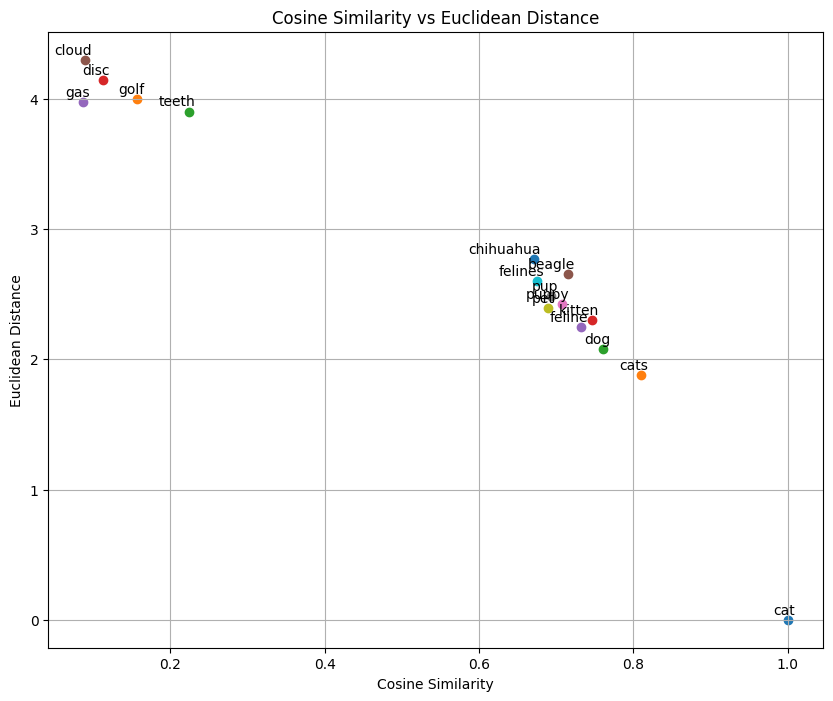

In [21]:
plt.figure(figsize=(10, 8))
for i, word in enumerate(words):
    x = cosinelist[i]
    y = euclideanlist[i]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.title('Cosine Similarity vs Euclidean Distance')
plt.xlabel('Cosine Similarity')
plt.ylabel('Euclidean Distance')
plt.grid(True)
plt.show()

We can see how while the metrics are mostly similar, there is a bit of difference between them. With the examples being mostly diagonal, it seems there is some relation between the two metrics.

**Use a heatmap to demonstrate and compare similarity and dissimilarity across
multiple (any number of your choice) word pairs.**

In [28]:
#Generate matrix of values for cosine similarity
heatmapmatrix = np.zeros((len(words), len(words)))
for i in range(len(words)):
  for j in range(len(words)):
    heatmapmatrix[i][j] = CosSimilar(Word2Vec_vectors[words[i]], Word2Vec_vectors[words[j]])



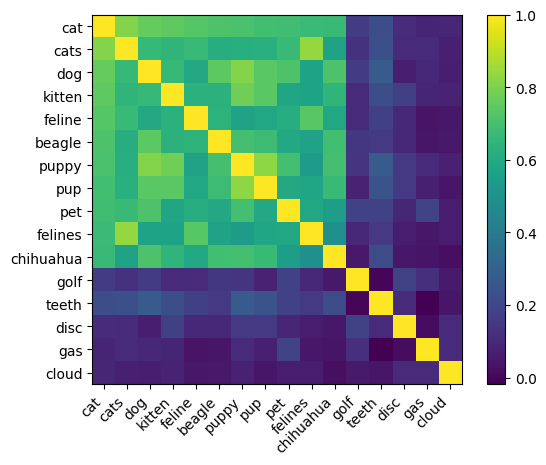

In [29]:
#Plot the heatmap
plt.imshow(heatmapmatrix, cmap='viridis')
plt.xticks(ticks=range(len(words)), labels=words, rotation=45, ha="right")
plt.yticks(ticks=range(len(words)), labels=words)
plt.colorbar()
plt.show()

In [30]:
#Generate matrix of values for euclidean distance
heatmapmatrix = np.zeros((len(words), len(words)))
for i in range(len(words)):
  for j in range(len(words)):
    heatmapmatrix[i][j] = EuclideanDistance(Word2Vec_vectors[words[i]], Word2Vec_vectors[words[j]])

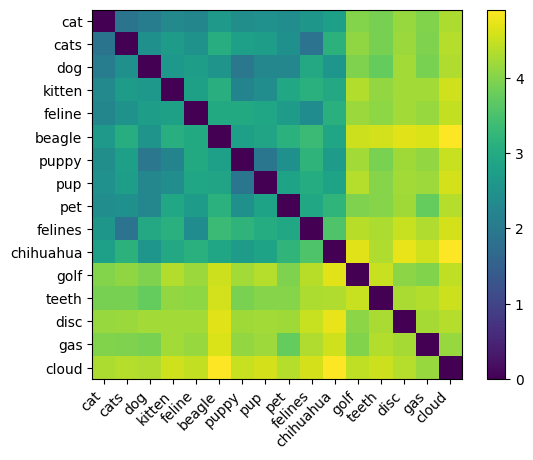

In [31]:
#Plot the heatmap
plt.imshow(heatmapmatrix, cmap='viridis')
plt.xticks(ticks=range(len(words)), labels=words, rotation=45, ha="right")
plt.yticks(ticks=range(len(words)), labels=words)
plt.colorbar()
plt.show()

As we can see, the words that were similar to cat were all similar to each other, and the random words that weren't similar to cat weren't very similar to each other, as well as just being dissimilar to cat and its similar words. This leads to having a big square of similarity, and the rest of the rectangle was dissimilar. There's also a diagonal of perfect similarity for both methods, but that's to be expected from comparing a word to itself.

Overall I'd say this homework went ok. Task 2 was definitely the harder of the 4000 level tasks, as I had I had difficulties trying to prevent overfitting, and while I did implement the RNN methods, overfitting was still at a crazy level. Task 3 had implementations that were a lot simpler by comparison, and the word embeddings were quite intuitive to use.